框架

    一、导入数据
    二、原始序列的检验
    三、一阶差分序列的检验
    四、定阶（参数调优)
    五、建模与预测
    
    参考材料：《Python数据分析与挖掘实践》

### 工具准备

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Simhei']
# 解决坐标轴刻度负号乱码
plt.rcParams['axes.unicode_minus'] = False

#pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  #自相关图、偏自相关图
from statsmodels.tsa.stattools import adfuller as ADF #平稳性检验
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
import statsmodels.api as sm #D-W检验,一阶自相关检验
from statsmodels.graphics.api import qqplot #画QQ图,检验一组数据是否服从正态分布
from statsmodels.tsa.arima_model import ARIMA

D:\anaconda\envs\transformer\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\envs\transformer\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\anaconda\envs\transformer\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


### 一、导入数据

In [3]:
sale=pd.read_excel('./shanghai.xls',index_col='Timestamp')
sale.head()

,Price
Timestamp,
1990-12-19,96.05
1990-12-20,104.30
1990-12-21,109.07
1990-12-24,113.57
1990-12-25,120.09


In [4]:
sale.tail()

,Price
Timestamp,
2019-02-22,2749.4615
2019-02-25,2838.3896
2019-02-26,2969.0976
2019-02-27,2939.9287
2019-02-28,2950.0548


In [4]:
sale.info()
print('-----')
sale.Price=sale.Price.astype('float')
sale.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6893 entries, 1990-12-19 to 2019-02-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   6893 non-null   float64
dtypes: float64(1)
memory usage: 107.7 KB
-----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6893 entries, 1990-12-19 to 2019-02-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   6893 non-null   float64
dtypes: float64(1)
memory usage: 107.7 KB


### 二、原始序列的检验

- 时序图

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

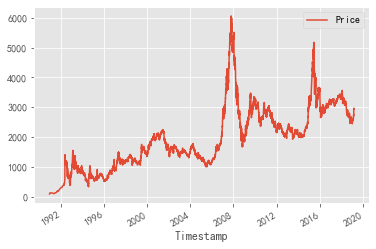

In [5]:
plt.figure(figsize=(10,5))
sale.plot()
plt.show()

#解读：具有单调递增趋势，则是非平稳序列。

- 自相关图

D:\anaconda\envs\transformer\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.


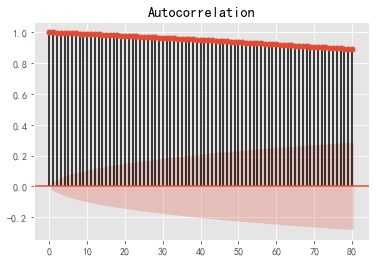

In [9]:
plot_acf(Shanghai Stock Exchange Index,lags=80).show()

#解读：自相关系数长期大于零，没有趋向于零，说明序列间具有很强的长期相关性。

- 平稳性检验

In [14]:
#方法：单位根检验

print('原始序列的ADF检验结果为：',ADF(Shanghai Stock Exchange Index.Price))

#解读：P值大于显著性水平α（0.05），接受原假设（非平稳序列），说明原始序列是非平稳序列。

原始序列的ADF检验结果为： (-2.0874011299902304, 0.24961075511894804, 32, 6860, {'1%': -3.43130360767153, '5%': -2.8619614166256566, '10%': -2.5669943162500317}, 71447.7133375078)


第一个是adf检验的结果。
第二个是统计量的P值。
第三个是计算过程中用到的延迟阶数。
第四个是用于ADF回归和计算的观测值的个数。
第五个是配合第一个一起看的，是在99%，95%，90%置信区间下的临界的ADF检验的值。

原文链接：https://blog.csdn.net/qq_36707798/article/details/88640684

### 三、一阶差分序列的检验

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

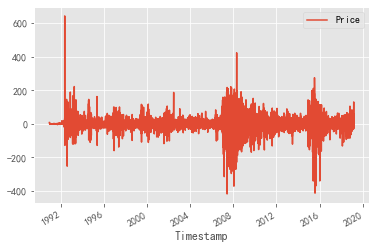

D:\anaconda\envs\transformer\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


原始序列的ADF检验结果为： (-14.717666390657104, 2.783536849958473e-27, 31, 6860, {'1%': -3.43130360767153, '5%': -2.8619614166256566, '10%': -2.5669943162500317}, 71440.68219685412)


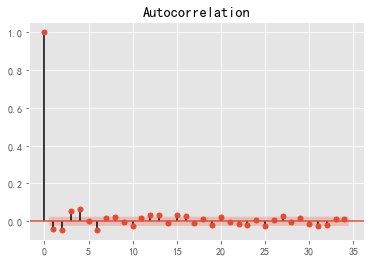

In [15]:
d1_sale=sale.diff(periods=1, axis=0).dropna()

#时序图
plt.figure(figsize=(10,5))
d1_sale.plot()
plt.show()
#解读：在均值附件比较平稳波动

#自相关图
plot_acf(d1_sale,lags=34).show()
#解读：有短期相关性，但趋向于零。

#平稳性检验
print('原始序列的ADF检验结果为：',ADF(d1_sale.Price))

#解读：P值小于显著性水平α（0.05），拒绝原假设（非平稳序列），说明一阶差分序列是平稳序列。

- 白噪声检验

In [10]:
print('一阶差分序列的白噪声检验结果为：',acorr_ljungbox(d1_sale,lags=1))#返回统计量、P值

#解读：p值小于0.05，拒绝原假设（纯随机序列），说明一阶差分序列是非白噪声。

一阶差分序列的白噪声检验结果为： (array([12.09356564]), array([0.00050596]))


D:\anaconda\envs\transformer\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


### 四、定阶

- 参数调优：人工识图

D:\anaconda\envs\transformer\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
D:\anaconda\envs\transformer\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
D:\anaconda\envs\transformer\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


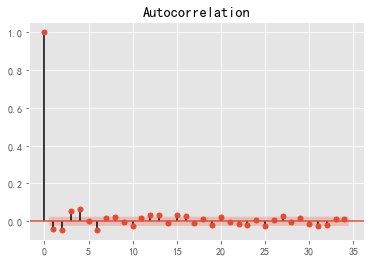

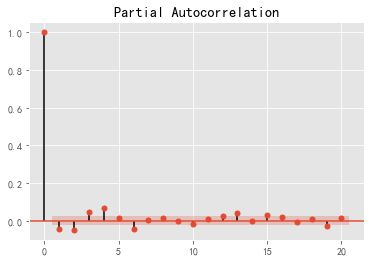

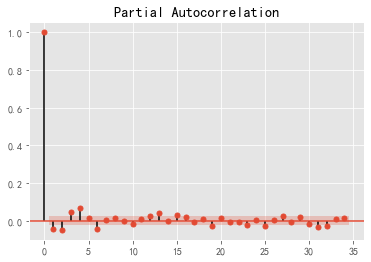

In [14]:
d1_sale=Shanghai Stock Exchange Index.diff(periods=1, axis=0).dropna()

#自相关图
plot_acf(d1_sale,lags=34).show()

#解读：有短期相关性，但趋向于零。

#偏自相关图
plot_pacf(d1_sale,lags=20).show()


#偏自相关图
plot_pacf(d1_sale,lags=34).show()

#解读：自相关图，1阶截尾；偏自相关图，拖尾。则ARIMA(p,d,q)=ARIMA(0,1,1)

- 参数调优：BIC

    模型调优的方法：AIC和BIC
    值越小越好
    参数调优的方法非常多，用不同方法得出的结论可能不同

In [16]:
pmax=int(len(d1_sale)/600) #一般阶数不超过length/10
qmax=int(len(d1_sale)/600) #一般阶数不超过length/10
pmax
qmax

11

11

In [17]:
bic_matrix=[]
for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(sale,(p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested an

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmod

In [18]:
bic_matrix=pd.DataFrame(bic_matrix)
bic_matrix

,0,1,2,3,4,5,6,7,8,9,10,11
0,71888.325973,71883.892690,71882.443313,71865.791383,71849.077171,71857.904214,71856.652522,71862.475771,71870.243614,71878.166923,71884.079617,71890.813043
1,71885.066790,71890.037952,71885.358196,71859.640394,71857.910599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71878.273467,71882.619229,71838.132784,71846.467863,71851.265597,71854.281465,NaN,NaN,NaN,NaN,NaN,NaN
3,71871.063458,71860.898338,71846.414393,71842.137640,71850.943735,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,71846.778386,71854.942055,71850.505109,71850.942098,71859.719834,71867.607048,NaN,NaN,NaN,NaN,NaN,NaN
5,71854.138386,71856.727412,71853.855135,71861.771894,71867.562223,71865.441518,NaN,NaN,NaN,NaN,NaN,NaN
6,71850.875565,71859.492324,71862.293561,71870.608942,71872.501964,71880.547393,71871.406396,NaN,NaN,NaN,NaN,NaN
7,71859.338922,71860.199941,71863.697414,71867.746815,71880.829276,71889.345675,71880.026931,71882.620730,NaN,NaN,NaN,NaN
8,71866.713822,71875.551298,71865.206241,71873.909322,71884.480718,71892.938907,71892.237837,71888.424153,71895.177503,NaN,NaN,NaN
9,71875.549764,71883.263464,71873.857385,71875.137064,71892.369074,71875.800434,71896.441103,71892.657365,71902.482737,NaN,NaN,NaN


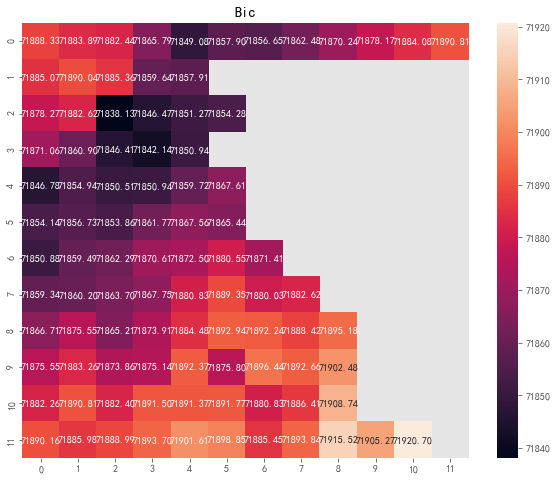

In [23]:
fig,ax=plt.subplots(figsize=(10,8))
ax=sns.heatmap(bic_matrix,
               mask=bic_matrix.isnull(),
               ax=ax,
               annot=True,
               fmt='.2f');
ax.set_title('Bic');


In [19]:
bic_matrix.stack()

0   0     71888.325973
    1     71883.892690
    2     71882.443313
    3     71865.791383
    4     71849.077171
              ...     
11  6     71885.447612
    7     71893.837552
    8     71915.524158
    9     71905.270625
    10    71920.704676
Length: 93, dtype: float64

In [20]:
p,q=bic_matrix.stack().idxmin() #最小值的索引
print('用BIC方法得到最优的p值是%d,q值是%d'%(p,q))

用BIC方法得到最优的p值是2,q值是2


- 参数调优：AIC

In [21]:
pmax=int(len(d1_sale)/600) #一般阶数不超过length/10
qmax=int(len(d1_sale)/600) #一般阶数不超过length/10

aic_matrix=[]
for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(sale,(p,1,q)).fit().aic)
        except:
            tmp.append(None)
    aic_matrix.append(tmp)
aic_matrix=pd.DataFrame(aic_matrix)
p,q=aic_matrix.stack().idxmin() #最小值的索引

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested an

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmod

In [22]:
print('用AIC方法得到最优的p值是%d,q值是%d'%(p,q))

用AIC方法得到最优的p值是11,q值是9


### 五、建模及预测

#### （1）建模

In [17]:
#创建模型
model=ARIMA(sale,(2,1,2)).fit()
#查看模型报告
model.summary2()

D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\envs\transformer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated f

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 71838.1328
Dependent Variable: D.Price          Log-Likelihood:      -35893.   
Date:               2021-09-26 09:59 Scale:               1.0000    
No. Observations:   6892             Method:              css-mle   
Df Model:           5                Sample:              1         
Df Residuals:       6887                                  3         
Converged:          1.0000           S.D. of innovations: 44.208    
No. Iterations:     25.0000          HQIC:                71811.253 
AIC:                71797.1041                                      
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            0.4152    0.5038    0.8242  0.4098  -0.5722   1.4026
ar.L1.D.Price    0.0933    0.0452    2.0657  0.0389   0.0048   0.1819
ar.L2.D.Price   -0.8007    0.0460  -17.3887  0.0000  -0.8909  -0.7104
ma.L1.D.Price   -0.1422    0.0488   -2.9174  0.0035  -0.2378  -0.0467
ma.L2.D.Price    0.7575    0.0507   14.9288  0.0000   0.6580   0.8569
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.0583            -1.1160           1.1176            -0.2417
AR.2            0.0583             1.1160           1.1176             0.2417
MA.1            0.0939            -1.1451           1.1490            -0.2370
MA.2            0.0939             1.1451           1.1490             0.2370
====================================================================

"""

#### （2）残差检验

D:\anaconda\envs\transformer\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
D:\anaconda\envs\transformer\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
D:\anaconda\envs\transformer\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


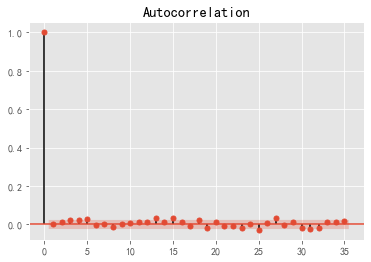

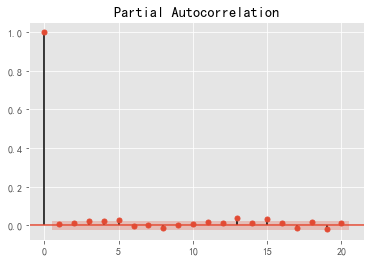

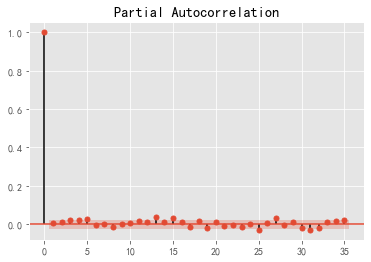

In [18]:
resid=model.resid

#自相关图
plot_acf(resid,lags=35).show()

#解读：有短期相关性，但趋向于零。

#偏自相关图
plot_pacf(resid,lags=20).show()

#偏自相关图
plot_pacf(resid,lags=35).show()

- QQ图

线性即正态分布

D:\anaconda\envs\transformer\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.


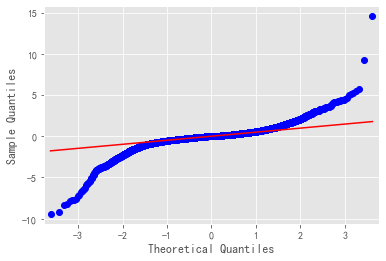

In [19]:
qqplot(resid, line='q', fit=True).show() 

#解读：残差服从正态分布，均值为零，方差为常数

- D-W检验

 德宾-沃森检验,简称D-W检验，是目前检验自相关性最常用的方法，但它只适用于检验一阶自相关性。
    因为自相关系数ρ的值介于-1和1之间，所以 0≤DW≤４。
- 并且DW＝O ＜ ＝＞ ρ＝１　　即存在正自相关性
- DW＝４   ＜＝＞  ρ＝－１　即存在负自相关性
- DW＝２   ＜＝＞  ρ＝０　　即不存在（一阶）自相关性

因此，当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。

原文链接：https://blog.csdn.net/u010414589/article/details/49622625

In [20]:
print('D-W检验的结果为：',sm.stats.durbin_watson(resid.values))  

#解读：不存在一阶自相关

D-W检验的结果为： 1.9900670128952234


- Ljung-Box检验

Ljung-Box test是对randomness的检验,或者说是对时间序列是否存在滞后相关的一种统计检验。对于滞后相关的检验，我们常常采用的方法还包括计算ACF和PCAF并观察其图像，但是无论是ACF还是PACF都仅仅考虑是否存在某一特定滞后阶数的相关。LB检验则是基于一系列滞后阶数，判断序列总体的相关性或者说随机性是否存在。
时间序列中一个最基本的模型就是高斯白噪声序列。而对于ARIMA模型，其残差被假定为高斯白噪声序列，所以当我们用ARIMA模型去拟合数据时，拟合后我们要对残差的估计序列进行LB检验，判断其是否是高斯白噪声，如果不是，那么就说明ARIMA模型也许并不是一个适合样本的模型。

检验的结果就是看最后一列前十二行的检验概率（一般观察滞后1~12阶），如果检验概率小于给定的显著性水平，比如0.05、0.10等就拒绝原假设，其原假设是相关系数为零。

原文链接：https://blog.csdn.net/u010414589/article/details/49622625

In [29]:
# 方法一
print('残差序列的白噪声检验结果为：',acorr_ljungbox(resid,lags=1))#返回统计量、P值

#解读：残差是白噪声 p>0.05

残差序列的白噪声检验结果为： (array([0.02374853]), array([0.87752649]))


D:\anaconda\envs\transformer\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [28]:
# 方法二
confint,qstat,pvalues = sm.tsa.acf(resid.values, qstat=True) #qstat is Ljung-Box Q-Statistic. confint is  Confidence intervals for the ACF
data = np.c_[range(1,41), confint[1:], qstat, pvalues]
table = pd.DataFrame(data, columns=['lag', "confint", "qstat", "pvalues(>Q)"])
print(table.set_index('lag'))

       confint      qstat  pvalues(>Q)
lag                                   
1.0   0.004958   0.169465     0.680588
2.0   0.012473   1.242320     0.537321
3.0   0.022990   4.887633     0.180213
4.0   0.021372   8.038367     0.090183
5.0   0.027424  13.226932     0.021342
6.0  -0.004088  13.342249     0.037912
7.0   0.003527  13.428074     0.062340
8.0  -0.012595  14.523030     0.069111
9.0   0.001743  14.543998     0.104247
10.0  0.005614  14.761563     0.141000
11.0  0.014598  16.232935     0.132701
12.0  0.011959  17.220589     0.141486
13.0  0.035375  25.864130     0.017729
14.0  0.014014  27.220739     0.018020
15.0  0.035341  35.849893     0.001858
16.0  0.015220  37.450646     0.001811
17.0 -0.009494  38.073572     0.002401
18.0  0.021493  41.266611     0.001399
19.0 -0.016701  43.194817     0.001219
20.0  0.015158  44.783482     0.001181
21.0 -0.008997  45.343193     0.001561
22.0 -0.005985  45.590935     0.002231
23.0 -0.016378  47.446369     0.001968
24.0  0.001656  47.465350

In [26]:
confint,qstat,pvalues = sm.tsa.acf(resid.values, qstat=True)
confint,qstat,pvalues

(array([ 1.        ,  0.00495761,  0.01247303,  0.02298991,  0.02137195,
         0.02742398, -0.00408811,  0.00352656, -0.01259535,  0.00174286,
         0.00561363,  0.01459751,  0.01195882,  0.03537531,  0.01401361,
         0.03534072,  0.01522025, -0.00949394,  0.02149308, -0.01670097,
         0.01515826, -0.00899671, -0.00598507, -0.01637802,  0.0016564 ,
        -0.02826788,  0.00710979,  0.0334088 , -0.00384189,  0.01414226,
        -0.02024444, -0.02358526, -0.01916214,  0.01046606,  0.01051159,
         0.01558364,  0.00953763,  0.02468944,  0.00371428,  0.00348395,
         0.0367938 ]),
 array([ 0.1694647 ,  1.24232037,  4.88763287,  8.03836684, 13.22693203,
        13.34224931, 13.42807436, 14.52302958, 14.54399794, 14.76156306,
        16.23293504, 17.22058866, 25.86413011, 27.2207388 , 35.84989282,
        37.45064617, 38.07357243, 41.26661129, 43.19481717, 44.78348235,
        45.3431934 , 45.59093462, 47.44636888, 47.46534981, 52.99421388,
        53.34401875, 61.0690

【补充说明】

    如果残差不是白噪声，可以考虑取另外一组p、q值；或者该数据不适应ARIMA模型。

#### （3）预测

In [37]:
#预测
print('未来70天的预测：')
model.forecast(70) #预测、标准差、置信区间

未来7天的销量预测：


(array([2961.3168473 , 2965.07232978, 2957.1144084 , 2954.07364801,
        2960.87053333, 2964.64848398, 2960.26783924, 2957.54295818,
        2961.5050598 , 2964.76551926, 2962.60634015, 2960.50313615,
        2962.74456928, 2965.34667149, 2964.50375768, 2963.05053698,
        2964.29872205, 2966.28769323, 2966.18283248, 2965.28941832,
        2965.99890385, 2967.48937027, 2967.76931141, 2967.31095535,
        2967.75294073, 2968.87009755, 2969.32938034, 2969.18666503,
        2969.5145135 , 2970.36828966, 2970.89437847, 2970.96878264,
        2971.26340455, 2971.94023575, 2972.47641414, 2972.69343682,
        2972.99329083, 2973.55641813, 2974.07779521, 2974.38447726,
        2974.70455039, 2975.197776  , 2975.69644002, 2976.05697134,
        2976.40025623, 2976.852532  , 2977.32878889, 2977.72001678,
        2978.0841076 , 2978.51374698, 2978.97123224, 2979.37883275,
        2979.75948176, 2980.17755725, 2980.62070538, 2981.03622681,
        2981.42909458, 2981.84196831, 2982.27484

In [44]:
forecast=pd.Series(model.forecast(70)[0],index=pd.date_range('2019-2-28',periods=70,freq='D'))
forecast

2019-02-28    2961.316847
2019-03-01    2965.072330
2019-03-02    2957.114408
2019-03-03    2954.073648
2019-03-04    2960.870533
                 ...     
2019-05-04    2985.169525
2019-05-05    2985.590870
2019-05-06    2986.010009
2019-05-07    2986.420671
2019-05-08    2986.832309
Freq: D, Length: 70, dtype: float64

<Figure size 7200x1440 with 0 Axes>

<Figure size 7200x1440 with 0 Axes>

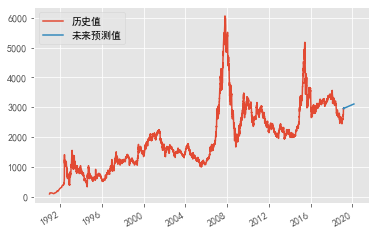

In [41]:
data=pd.concat((sale,forecast),axis=0)
data.columns=['历史值','未来预测值']
plt.figure(figsize=(100,20))
data.plot()
plt.show()

TypeError: 'DataFrame' object is not callable